# The Battle of Neighborhoods- Coursera Capstone Project: Finding a place to open a profitable Afghani resturant
## Table of Content
1. Introduction: Business Problem
2. Data
3. Methodology
4. Analysis
5. Discussion
6. Results / Conclusion

## 1. Introduction: Business Problem
The final project for the Coursera course: Applied Data Science Capstone of IBM Data Science Professional Certificate is to apply the learning from all the courses of that certificate. In Module 3, we explored New York City and the city of Toronto and segmented and clustered their neighborhoods. Both cities are very diverse and are the financial capitals of their respective countries. In Module 4, we have to come up with an idea of real data science problem and find its solution. 
### Background information:
New York is a major metropolitan area with more than 8.4 million (Quick Facts, 2018) people living within city limits. New York City is the largest city in the United States with a long history of international immigration. People came from many parts of the world. According to the 2007 American Community Survey estimates, New York City is home to approximately 50,000 people from Afghanistan. With its diverse culture, comes diverse food items. There are many restaurants in New York City, each belonging to different categories like Chinese, Indian, French, etc. I know that New Yorkers are open to new ideas and food and they would try and taste food from other countries. 
### Problem statement:
Long before starting university, I always an idea in my mind to open an authentic Afghani restaurant, especially the afghani bread and kabebs are best. So in this final project, I will work on that idea and try to find the best place in New York City to open an authentic Afghani restaurant.

### Target audience for this report
Business personnel who wants to invest or open a restaurant.

Finding the best location for opening a profitable restaurant.

Exploratory Data Analysis techniques to obtain necessary data, analyze it and, finally be able to tell a story out of it.


## 2. Data Section

For this project we need the following data:
1. New York City data that contains Borough, Neighborhoods along with there latitudes and longitudes
- Data Source: https://cocl.us/new_york_dataset
- Description: This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
2. Afghani restaurants in New York City
- Data Source: Foursquare API
- Description: By using this API we will get all the venues in the New York City. We can filter these venues to get only Afghani restaurants.

## 3. Methodology

- Collect the new york city data from https://cocl.us/new_york_dataset.
- Using Foursquare API we will get all venues for each neighborhood.
- Filter out all venues which are Afghani Restaurants.
- Data Visualization and some statistical analysis.
- Analyzing using Clustering (Specially K-Means):
    1. Find the best value of K
    2. Visualize the neighborhood with a number of Afghani Restaurants.
- Compare the Neighborhoods to Find the Best Place for Starting up a Restaurant.
- Inference From these Results and related Conclusions

**Before we get the data and start exploring it, let's import all required libraries.**

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


**My Foursquare Credentials and version**

In [3]:
# Define Foursquare Credentials and Version
# Liaquat Credentials
CLIENT_ID = '########' # your Foursquare ID
CLIENT_SECRET = '######' # your Foursquare Secret
ACCESS_TOKEN = '######' # your FourSquare Access Token
VERSION = '20180604'

# Ifrah Credentials
CLIENT_ID = '#####' # your Foursquare ID
CLIENT_SECRET = '######' # your Foursquare Secret
ACCESS_TOKEN = '######' # your FourSquare Access Token
VERSION = '20180604'


We will get New York City data such as Borough, Neighborhood along with latitude and longtiude from the website 

In [4]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

Now we will convert that data into Pandas dataframe so that we can apply different anaylsis on the data. 

In [5]:
ny_data = get_new_york_data()
ny_data.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [6]:
ny_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York.

## 4. Analysis

Let analyze the initial data.

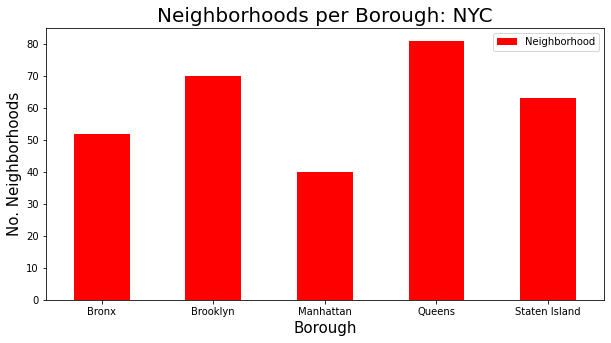

In [7]:
clr = "red"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

**Let's analyze further and see how many Afghani restaurants there are in each neighborhood and borough. After it, graph the results.**

In [8]:
def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    #print(url)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [9]:
# queens has most neighborhoods
# prepare neighborhood list that contains Afghan restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
afghan_rest_ny=pd.DataFrame(columns=column_names)

count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    afghan_restaurants=venues[venues['Category']=='Afghan Restaurant']   
    print('(',count,'/',len(ny_data),')','Afghan Restaurants in '+Neighborhood+', '+Borough+':'+str(len(afghan_restaurants)))
    print(row)
    for resturant_detail in afghan_restaurants.values.tolist():
        id, name , category=resturant_detail
        afghan_rest_ny = afghan_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1


( 1 / 306 ) Afghan Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Afghan Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Afghan Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Afghan Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Afghan Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Afghan Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Afghan Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Afghan Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Afghan Restaurants in Norwood, Bronx:0
['Bronx', '

( 68 / 306 ) Afghan Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Afghan Restaurants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Afghan Restaurants in Fort Greene, Brooklyn:0
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Afghan Restaurants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Afghan Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Afghan Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Afghan Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Afghan Restaurants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]


( 132 / 306 ) Afghan Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Afghan Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Afghan Restaurants in Howard Beach, Queens:0
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Afghan Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Afghan Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Afghan Restaurants in Kew Gardens, Queens:0
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Afghan Restaurants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) Afghan Restaurants in Flushing, Queens:0
['Queens', 'Flushing', 40.76445419697846, -73.83177300329582]
( 140 / 306 ) Afghan Re

( 199 / 306 ) Afghan Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Afghan Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Afghan Restaurants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Afghan Restaurants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Afghan Restaurants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Afghan Restaurants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Afghan Restaurants in South Beach, Staten Island:0
['Staten Island', 'South Beach', 40.58024741350956, -74.0795529253982]
( 206 / 306 ) Afghan Restaurants in Port Richmond, 

( 260 / 306 ) Afghan Restaurants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Afghan Restaurants in New Lots, Brooklyn:0
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Afghan Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Afghan Restaurants in Mill Basin, Brooklyn:0
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Afghan Restaurants in Jamaica Hills, Queens:0
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Afghan Restaurants in Utopia, Queens:1
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Afghan Restaurants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120040537]
( 267 / 306 ) Afghan Restaurants in Astoria Heights, Queens:0
['Queens', 'Astoria Heights', 40.7703173929982, -73.89467996270574]
(

In [12]:
#afghan_rest_ny.to_csv('afghan_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
afghan_rest_ny.to_csv('afghan_rest_ny_tocsv1.csv')

In [13]:
afghan_ny = pd.read_csv('afghan_rest_ny_tocsv1.csv')
afghan_rest_ny.tail()

Borough Neighborhood                        ID  \
0  Manhattan   Lenox Hill  4b22ec71f964a520685024e3   
1     Queens   Ravenswood  582a1b095f78034bcfb69186   
2     Queens       Utopia  4b6740aaf964a520fb432be3   

                          Name  
0        Afghan Kebab House II  
1           Sami's Kebab House  
2  Bakhter Afghan Halal Kababs

In [14]:
afghan_rest_ny.shape

(3, 4)

We got 3 Afghan Restaurants across the New York City.

As we continue our analysis, we see below that Manhattan has one resturant and Queens has two resturant. 

Now we will get the ranking of each restaurant for further analysis.


In [15]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
afghan_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in afghan_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(afghan_rest_ny),')','processed')
    afghan_rest_stats_ny = afghan_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
afghan_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '60479eeee377ec72d268abe4'}, 'response': {'venue': {'id': '4b22ec71f964a520685024e3', 'name': 'Afghan Kebab House II', 'contact': {'phone': '7188139556', 'formattedPhone': '(718) 813-9556', 'twitter': 'kebabhouseii', 'facebook': '1014488891970711', 'facebookName': 'Afghan Kebab House II'}, 'location': {'address': '1345 2nd Ave', 'crossStreet': 'btw. 70th and 71st St', 'lat': 40.76802139999999, 'lng': -73.95915719999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76802139999999, 'lng': -73.95915719999999}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1345 2nd Ave (btw. 70th and 71st St)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/afghan-kebab-house-ii/4b22ec71f964a520685024e3', 'categories': [{'id': '503288ae91d4c4b30a586d67', 'name': 'Afghan Restaurant', 'pluralName': 'Afghan Restaurants', 'shortName': 'Afghan', 'icon': {'prefix

{'meta': {'code': 200, 'requestId': '60479eef005d346812ea89c9'}, 'response': {'venue': {'id': '4b6740aaf964a520fb432be3', 'name': 'Bakhter Afghan Halal Kababs', 'contact': {}, 'location': {'address': '68-16 Fresh Meadow Ln', 'lat': 40.73320466046026, 'lng': -73.79464539951913, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73320466046026, 'lng': -73.79464539951913}], 'postalCode': '11365', 'cc': 'US', 'city': 'Fresh Meadows', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['68-16 Fresh Meadow Ln', 'Fresh Meadows, NY 11365', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bakhter-afghan-halal-kababs/4b6740aaf964a520fb432be3', 'categories': [{'id': '503288ae91d4c4b30a586d67', 'name': 'Afghan Restaurant', 'pluralName': 'Afghan Restaurants', 'shortName': 'Afghan', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/afghan_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 21}, 'price': {'tier': 1, 'message': 'Cheap'

Borough Neighborhood                        ID  \
0  Manhattan   Lenox Hill  4b22ec71f964a520685024e3   
1     Queens   Ravenswood  582a1b095f78034bcfb69186   
2     Queens       Utopia  4b6740aaf964a520fb432be3   

                          Name Likes  Rating Tips  
0        Afghan Kebab House II    19     7.8   11  
1           Sami's Kebab House    20     8.1    4  
2  Bakhter Afghan Halal Kababs    23     6.8   21

In [16]:
afghan_rest_stats_ny.to_csv('afghan_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file
afghan_rest_stats_ny.shape

(3, 7)

We got statistics for all 3 Afghan Restaurants in New York city.

Let's check what values we have in our DataFrame

In [17]:
afghan_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       3 non-null      object 
 1   Neighborhood  3 non-null      object 
 2   ID            3 non-null      object 
 3   Name          3 non-null      object 
 4   Likes         3 non-null      object 
 5   Rating        3 non-null      float64
 6   Tips          3 non-null      object 
dtypes: float64(1), object(6)
memory usage: 296.0+ bytes


We see that the values like Likes, Tips are string values. We would need to convert them into float for further analysis

In [18]:
afghan_rest_stats_ny['Likes'] = afghan_rest_stats_ny['Likes'].astype('float64')
afghan_rest_stats_ny['Tips'] = afghan_rest_stats_ny['Tips'].astype('float64')
afghan_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       3 non-null      object 
 1   Neighborhood  3 non-null      object 
 2   ID            3 non-null      object 
 3   Name          3 non-null      object 
 4   Likes         3 non-null      float64
 5   Rating        3 non-null      float64
 6   Tips          3 non-null      float64
dtypes: float64(3), object(4)
memory usage: 296.0+ bytes


In [19]:
afghan_rest_stats_ny.describe()

Likes    Rating       Tips
count   3.000000  3.000000   3.000000
mean   20.666667  7.566667  12.000000
std     2.081666  0.680686   8.544004
min    19.000000  6.800000   4.000000
25%    19.500000  7.300000   7.500000
50%    20.000000  7.800000  11.000000
75%    21.500000  7.950000  16.000000
max    23.000000  8.100000  21.000000

In [20]:
# Resturant with maximum Like
afghan_rest_stats_ny.iloc[afghan_rest_stats_ny['Likes'].idxmax()]

Borough                              Queens
Neighborhood                         Utopia
ID                 4b6740aaf964a520fb432be3
Name            Bakhter Afghan Halal Kababs
Likes                                  23.0
Rating                                  6.8
Tips                                   21.0
Name: 2, dtype: object

In [21]:
# Resturant with maximum Ratings
afghan_rest_stats_ny.iloc[afghan_rest_stats_ny['Rating'].idxmax()]

Borough                           Queens
Neighborhood                  Ravenswood
ID              582a1b095f78034bcfb69186
Name                  Sami's Kebab House
Likes                               20.0
Rating                               8.1
Tips                                 4.0
Name: 1, dtype: object

In [22]:
# Resturant with maximum Tips
afghan_rest_stats_ny.iloc[afghan_rest_stats_ny['Tips'].idxmax()]

Borough                              Queens
Neighborhood                         Utopia
ID                 4b6740aaf964a520fb432be3
Name            Bakhter Afghan Halal Kababs
Likes                                  23.0
Rating                                  6.8
Tips                                   21.0
Name: 2, dtype: object

In [23]:
ny_neighborhood_stats=afghan_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head()

Neighborhood  Average Rating
1   Ravenswood             8.1
0   Lenox Hill             7.8
2       Utopia             6.8

Above are the top neighborhoods with the highest average ratings of Afghan restaurants.

In [24]:
ny_borough_stats=afghan_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

Borough  Average Rating
0  Manhattan            7.80
1     Queens            7.45

Similarly these are the average ratings of Afghan Restaurants for each Borough

## 5. Discussion 

From the data of the Foursquare API, we can see that there are only three afghani resturants in New York City, which is very unusual. I think the data is not that much updated or the afghani resturants are not group accordingly. The afghani resturants might be mistaken with Irani/Persian resturant as these two couisins are much similar. These could be another project to include the Afghani and Irani resturant together and see their ratings and likes. For this project, we will just consider the afghani resturant for further data analysis and result/conclusion. 


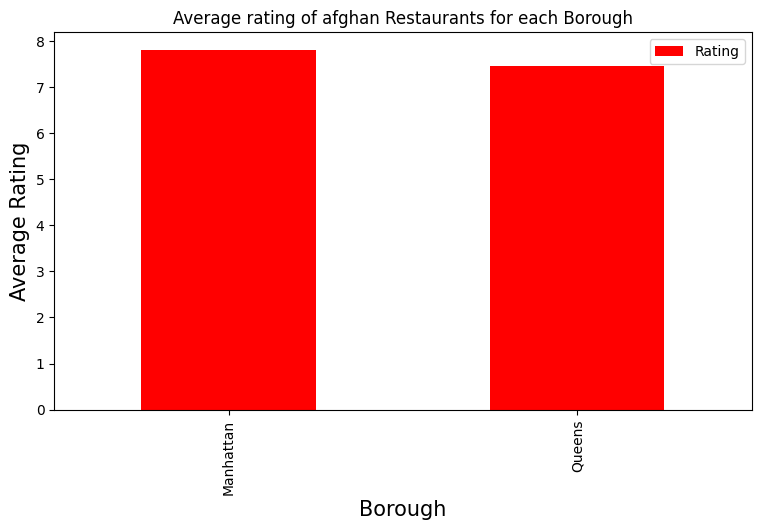

In [25]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of afghan Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
afghan_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

We will join this Dataset to original New York data to get longitude and latitude

In [26]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

Borough Neighborhood   Latitude  Longitude  Average Rating
0  Manhattan   Lenox Hill  40.768113 -73.958860             7.8
1     Queens   Ravenswood  40.761705 -73.931575             8.1
2     Queens       Utopia  40.733500 -73.796717             6.8

In [27]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [28]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

## 5.Results / Conclusion

From the figure above, we can see that the Manhattan has one afghani resturant and Queens have two afghani resturants. So there is very good opportunity to open an afghani resturant in neighborhood other than these two. From these information, we cannot conclude much where to open a new afghani resturants which will give us the most profits. Based on the rating, likes and tips, I would say that the afghani resturant in Queens neighborhood and in Utopia borough is the best one, that I would visit. I would not open a new resturant near that one. For further evaluation of opening a afghani resturant one should take consideration of the population data of the afghani origin people living in New York City. If we can combine that data with the data above then we can also make a very good decision to open a afghani resturant where the population of the Afghani people are more and there might not be a afghani resturant near to them or may have not good rating and likes. As a final note, all of the above analyses is depended on the adequacy and accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.

Finally, to conclude this project, we have got a small glimpse of how a real-life Data science project looks like. I have used some frequently used python libraries to handle JSON file, plotting graphs, and other exploratory data analysis. Use Foursquare API to major boroughs of New York City and their neighborhoods.The potential for this kind of analysis in a real-life business problem is discussed in great detail. I would like to thank you Coursera and IBM for a such a great course and specilization certificate. 